In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [26]:
def load_data(file_path):
    """
    Load the dataset into a pandas DataFrame
    """
    df = pd.read_csv(file_path)
    return df

In [27]:
def calculate_prior_probabilities(df, target_column):
    """
    Calculate prior probabilities for each class in the target column
    """
    target_counts = df[target_column].value_counts()
    total_instances = len(df)
    prior_probs = {}
    
    for target_value, count in target_counts.items():
        prior_probs[target_value] = count / total_instances
    
    return prior_probs

In [28]:
def calculate_conditional_probabilities(df, features, target_column):
    """
    Calculate conditional probabilities for each feature given each class
    """
    conditional_probs = {}
    target_values = df[target_column].unique()
    
    for feature in features:
        conditional_probs[feature] = {}
        feature_values = df[feature].unique()
        
        for target_value in target_values:
            conditional_probs[feature][target_value] = {}
            target_df = df[df[target_column] == target_value]
            target_count = len(target_df)
            
            for feature_value in feature_values:
                count = len(target_df[target_df[feature] == feature_value])
                conditional_probs[feature][target_value][feature_value] = count / target_count
    
    return conditional_probs

In [29]:
def predict(prior_probs, conditional_probs, new_instance, df):
    """
    Predict the class for a new instance using Naïve Bayes
    """
    predictions = {}
    
    for target_value, prior_prob in prior_probs.items():
        posterior_prob = prior_prob
        
        for feature, feature_value in new_instance.items():
            if feature in conditional_probs and feature_value in conditional_probs[feature][target_value]:
                posterior_prob *= conditional_probs[feature][target_value][feature_value]
            else:
                # Laplace smoothing (add-one) for unseen values
                feature_values_count = len(conditional_probs[feature][target_value])
                posterior_prob *= 1 / (len(df[df['play'] == target_value]) + feature_values_count)
        
        predictions[target_value] = posterior_prob
    
    # Normalize the probabilities
    total_prob = sum(predictions.values())
    if total_prob > 0:
        for target_value in predictions:
            predictions[target_value] /= total_prob
    
    # Return the class with the highest posterior probability
    return max(predictions, key=predictions.get), predictions

In [30]:
def get_user_input(features, df):
    """
    Get feature values from the user
    """
    user_input = {}
    print("Please enter the feature values:")
    for feature in features:
        if feature == 'day':
            continue  # Skip the day feature as it's just an identifier
        
        # Get unique values for this feature
        unique_values = sorted(df[feature].unique())
        
        # Display options with numbers
        print(f"\nSelect {feature} (Enter the number):")
        for i, value in enumerate(unique_values, 1):
            print(f"  {i}. {value}")
        
        # Get user selection
        while True:
            try:
                selection = int(input("Enter your choice: "))
                if 1 <= selection <= len(unique_values):
                    user_input[feature] = unique_values[selection - 1]
                    break
                else:
                    print(f"Please enter a number between 1 and {len(unique_values)}")
            except ValueError:
                print("Please enter a valid number")
    
    return user_input

In [31]:
def visualize_data(df, features, target_column):
    """
    Create visualizations for the dataset
    """
    # Setting the style
    sns.set(style="whitegrid")
    
    # Filtering out 'day' from features for visualization
    vis_features = [f for f in features if f != 'day']
    
    # Create a figure with subplots - adjust based on number of features
    num_plots = 1 + len(vis_features)  # 1 for target distribution + 1 for each feature
    fig_rows = 2
    fig_cols = (num_plots + 1) // 2  # Ensure we have enough columns
    
    plt.figure(figsize=(15, 10))
    
    # 1. Distribution of target variable
    plt.subplot(fig_rows, fig_cols, 1)
    target_counts = df[target_column].value_counts()
    colors = ['#FF9999', '#66B2FF']
    ax = target_counts.plot(kind='bar', color=colors)
    plt.title('Distribution of Play Tennis Decision', fontsize=14)
    plt.xlabel('Decision', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Add count labels on top of each bar
    for i, v in enumerate(target_counts):
        ax.text(i, v + 0.1, str(v), ha='center', fontsize=10)
    
    # 2. Feature distribution by target variable (in a grid)
    for i, feature in enumerate(vis_features, 1):
        plt.subplot(fig_rows, fig_cols, i + 1)
        
        # Create a crosstab for this feature and target
        cross_tab = pd.crosstab(df[feature], df[target_column])
        
        # Plot stacked bar chart
        cross_tab.plot(kind='bar', stacked=True, color=colors)
        plt.title(f'Distribution of {feature} by Decision', fontsize=14)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(title='Play Tennis')
    
    plt.tight_layout()
    plt.show()

In [32]:
def visualize_prediction(probabilities, prediction):
    """
    Visualize the prediction results
    """
    # Create a figure
    plt.figure(figsize=(10, 6))
    
    # Plot the probabilities
    classes = list(probabilities.keys())
    probs = list(probabilities.values())
    
    # Define colors based on the prediction
    colors = ['#66B2FF' if c == prediction else '#FF9999' for c in classes]
    
    # Create the bar chart
    plt.bar(classes, probs, color=colors)
    
    # Add text annotations
    for i, (c, p) in enumerate(zip(classes, probs)):
        plt.text(i, p + 0.02, f'{p:.4f}', ha='center', fontsize=12)
    
    # Set labels and title
    plt.xlabel('Play Tennis Decision', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.title('Naïve Bayes Prediction Probabilities', fontsize=14)
    plt.ylim(0, 1.1)
    
    # Add a horizontal line at 0.5 for reference
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    
    # Add a text box with the final prediction
    decision_text = f"Decision: {'Play Tennis' if prediction == 'Yes' else 'Do Not Play Tennis'}"
    plt.annotate(decision_text, 
                 xy=(0.5, 0.9), 
                 xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc='#EAFAF1', ec="black", lw=1),
                 ha='center', 
                 fontsize=14)
    
    plt.tight_layout()
    plt.show()

In [33]:
def visualize_probabilities(prior_probs, conditional_probs, features):
    """
    Visualize the computed probabilities
    """
    # Filtering out 'day' from features for visualization
    vis_features = [f for f in features if f != 'day']
    
    # Create a figure with subplots - adjust based on number of features
    num_plots = 1 + len(vis_features)  # 1 for prior probs + 1 for each feature
    if num_plots <= 4:
        fig_rows, fig_cols = 2, 2
    else:
        fig_rows = (num_plots + 1) // 2
        fig_cols = 2
    
    plt.figure(figsize=(15, 5 * fig_rows))
    
    # 1. Prior probabilities
    plt.subplot(fig_rows, fig_cols, 1)
    classes = list(prior_probs.keys())
    probs = list(prior_probs.values())
    colors = ['#66B2FF', '#FF9999']
    
    plt.bar(classes, probs, color=colors)
    plt.title('Prior Probabilities P(play)', fontsize=14)
    plt.xlabel('Play Tennis Decision', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.ylim(0, 1)
    
    # Add text annotations
    for i, (c, p) in enumerate(zip(classes, probs)):
        plt.text(i, p + 0.02, f'{p:.4f}', ha='center', fontsize=10)
    
    # 2. Conditional probabilities for each feature
    for i, feature in enumerate(vis_features, 1):
        plt.subplot(fig_rows, fig_cols, i + 1)
        
        # Extract data for this feature
        feature_values = sorted(conditional_probs[feature]['Yes'].keys())
        yes_probs = [conditional_probs[feature]['Yes'][val] for val in feature_values]
        no_probs = [conditional_probs[feature]['No'][val] for val in feature_values]
        
        # Set up the bar positions
        x = np.arange(len(feature_values))
        width = 0.35
        
        # Create grouped bar chart
        plt.bar(x - width/2, yes_probs, width, label='Yes', color='#66B2FF')
        plt.bar(x + width/2, no_probs, width, label='No', color='#FF9999')
        
        plt.title(f'P({feature}|play)', fontsize=14)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Probability', fontsize=12)
        plt.xticks(x, feature_values, rotation=45, fontsize=10)
        plt.ylim(0, 1)
        plt.legend()
        
        # Add text annotations
        for i, (y, n) in enumerate(zip(yes_probs, no_probs)):
            plt.text(i - width/2, y + 0.02, f'{y:.2f}', ha='center', fontsize=8)
            plt.text(i + width/2, n + 0.02, f'{n:.2f}', ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [34]:
def output_summary(prior_probs, conditional_probs, features, target_column, df):
    """
    Display a summary of the model probabilities in a user-friendly format
    """
    print("\n" + "="*60)
    print(f"{' NAÏVE BAYES MODEL SUMMARY ':=^60}")
    print("="*60)
    
    # Print dataset information
    print(f"\nDataset Information:")
    print(f"- Total instances: {len(df)}")
    print(f"- Target variable: {target_column}")
    print(f"- Features: {', '.join([f for f in features if f != 'day'])}")
    
    # Print prior probabilities
    print("\nPrior Probabilities:")
    for target_value, prob in prior_probs.items():
        print(f"  P(play={target_value}) = {prob:.4f}")
    
    # Print conditional probabilities
    print("\nConditional Probabilities:")
    for feature in features:
        if feature == 'day':  # Skip day feature
            continue
        print(f"\n  Feature: {feature}")
        for target_value in sorted(df[target_column].unique()):
            print(f"    For play={target_value}:")
            for feature_value in sorted(conditional_probs[feature][target_value].keys()):
                prob = conditional_probs[feature][target_value][feature_value]
                print(f"      P({feature}={feature_value}|play={target_value}) = {prob:.4f}")
    
    print("\n" + "="*60)



Visualizing the dataset...


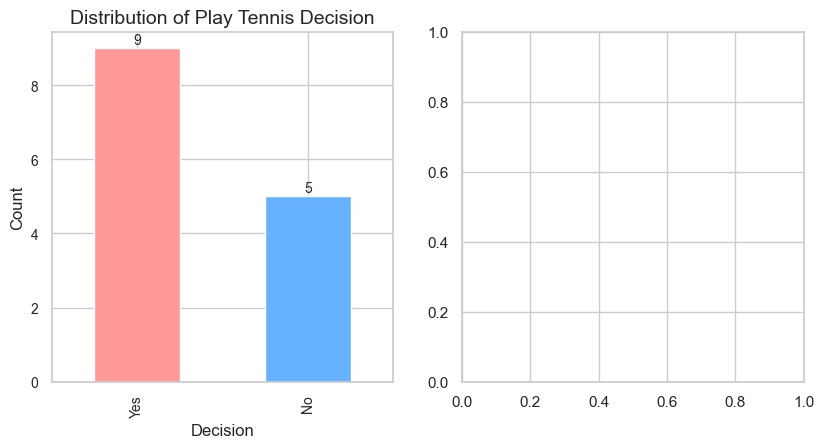

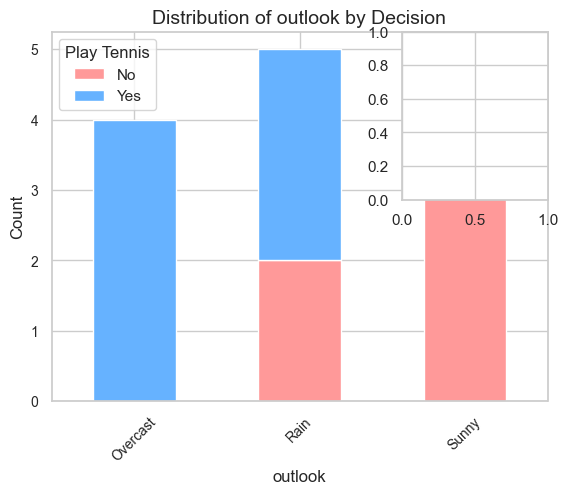

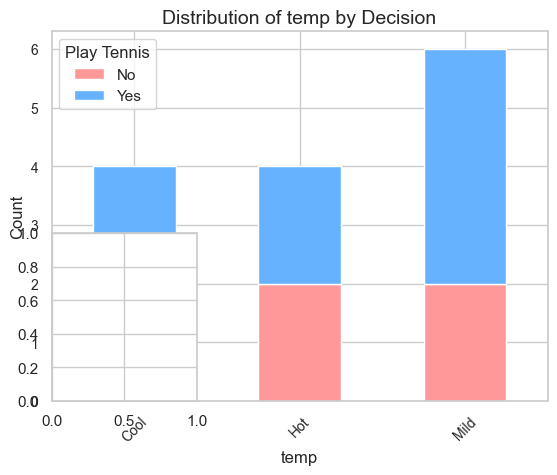

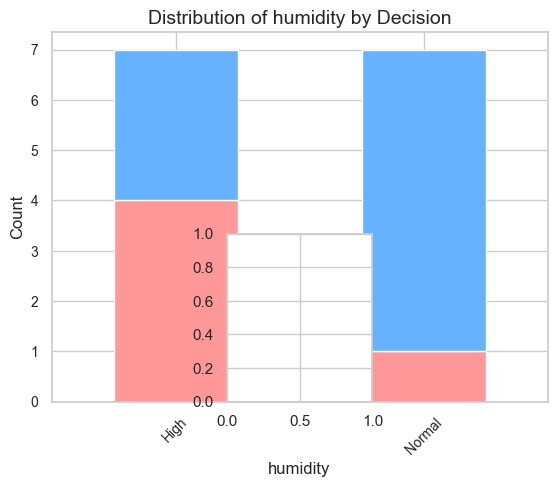

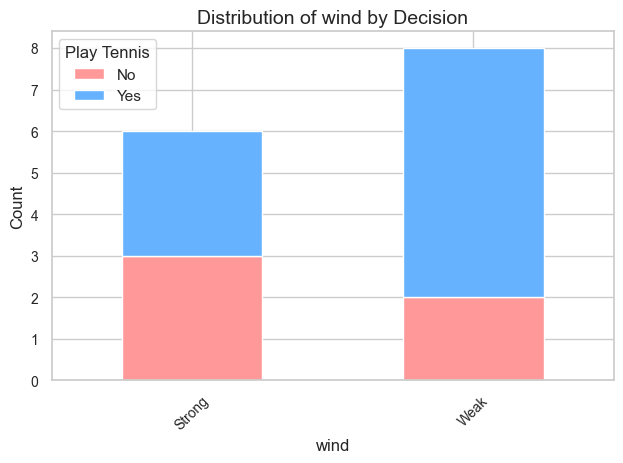


================ NAÏVE BAYES MODEL SUMMARY =================

Dataset Information:
- Total instances: 14
- Target variable: play
- Features: outlook, temp, humidity, wind

Prior Probabilities:
  P(play=Yes) = 0.6429
  P(play=No) = 0.3571

Conditional Probabilities:

  Feature: outlook
    For play=No:
      P(outlook=Overcast|play=No) = 0.0000
      P(outlook=Rain|play=No) = 0.4000
      P(outlook=Sunny|play=No) = 0.6000
    For play=Yes:
      P(outlook=Overcast|play=Yes) = 0.4444
      P(outlook=Rain|play=Yes) = 0.3333
      P(outlook=Sunny|play=Yes) = 0.2222

  Feature: temp
    For play=No:
      P(temp=Cool|play=No) = 0.2000
      P(temp=Hot|play=No) = 0.4000
      P(temp=Mild|play=No) = 0.4000
    For play=Yes:
      P(temp=Cool|play=Yes) = 0.3333
      P(temp=Hot|play=Yes) = 0.2222
      P(temp=Mild|play=Yes) = 0.4444

  Feature: humidity
    For play=No:
      P(humidity=High|play=No) = 0.8000
      P(humidity=Normal|play=No) = 0.2000
    For play=Yes:
      P(humidity=High|pl

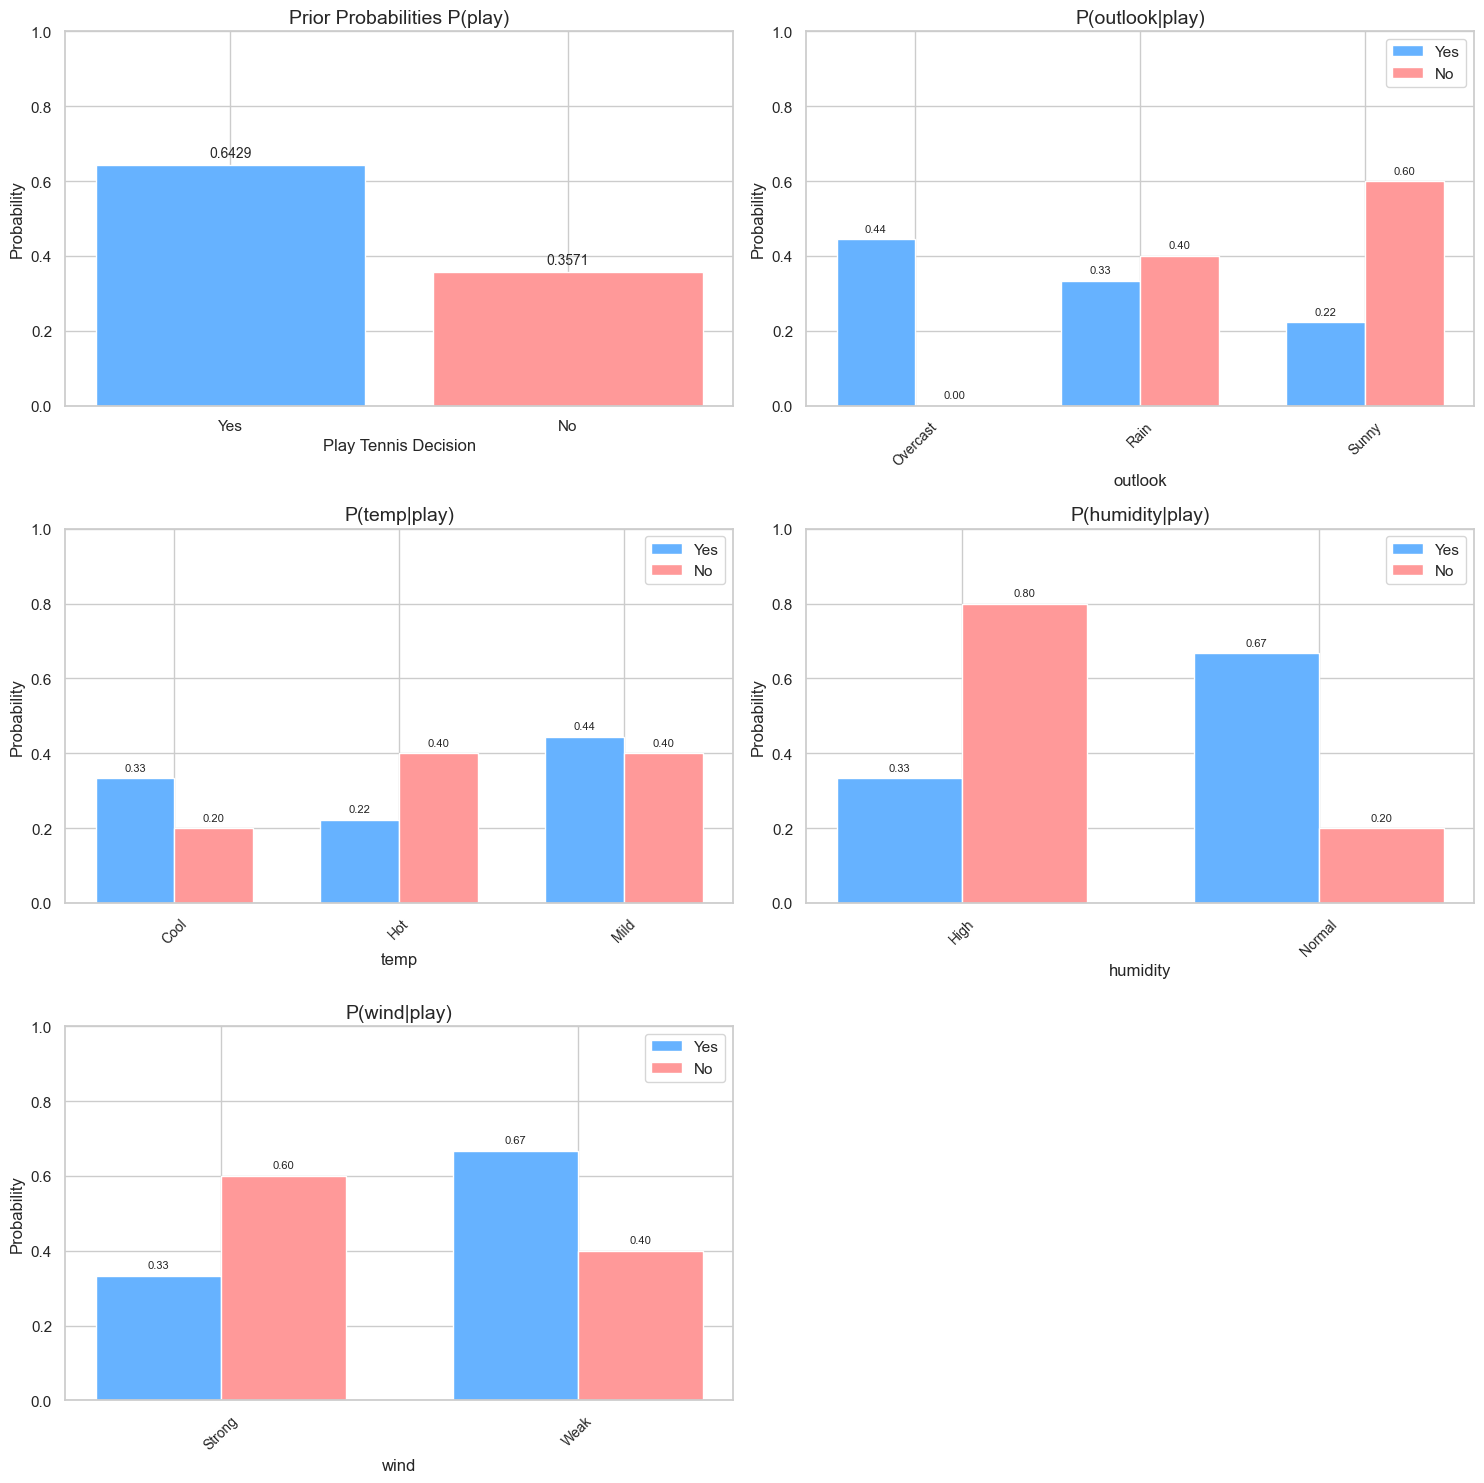


======================== PREDICTION ========================
Please enter the feature values:

Select outlook (Enter the number):
  1. Overcast
  2. Rain
  3. Sunny

Select temp (Enter the number):
  1. Cool
  2. Hot
  3. Mild

Select humidity (Enter the number):
  1. High
  2. Normal

Select wind (Enter the number):
  1. Strong
  2. Weak

Your selected inputs:
  outlook: Sunny
  temp: Hot
  humidity: Normal
  wind: Strong

Prediction Results:
  P(play=Yes|evidence) = 0.4068
  P(play=No|evidence) = 0.5932

Final prediction: You should not play tennis.

Visualizing the prediction...


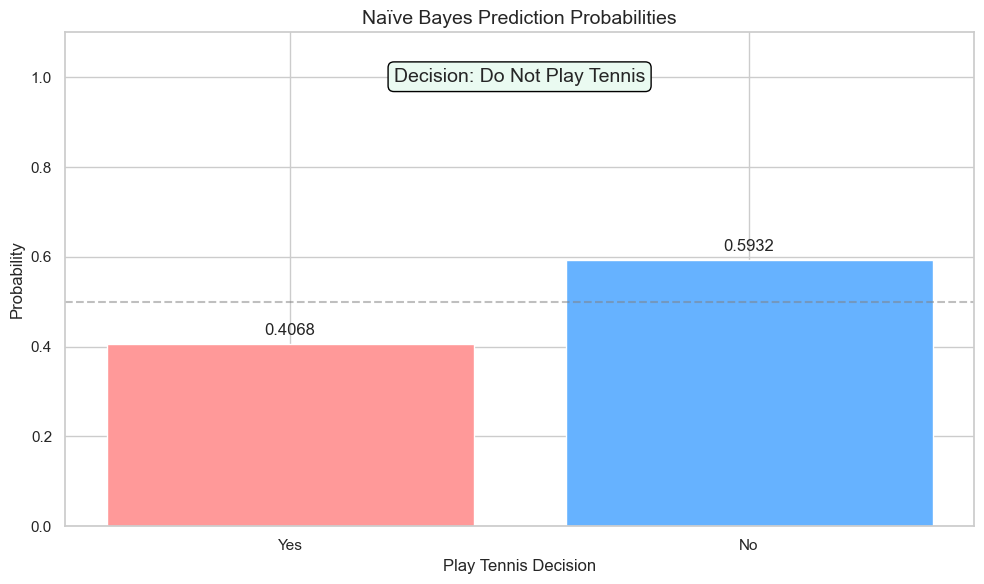

In [35]:
if __name__ == "__main__":
    # Load the dataset
    df = load_data('play_tennis.csv')
    
    # Define features and target
    features = ['outlook', 'temp', 'humidity', 'wind']
    target_column = 'play'
    
    # Visualize the dataset
    print("\nVisualizing the dataset...")
    visualize_data(df, features, target_column)
    
    # Calculate prior probabilities
    prior_probs = calculate_prior_probabilities(df, target_column)
    
    # Calculate conditional probabilities
    conditional_probs = calculate_conditional_probabilities(df, features, target_column)
    
    # Display probabilities
    output_summary(prior_probs, conditional_probs, features, target_column, df)
    
    # Visualize probabilities
    print("\nVisualizing the probabilities...")
    visualize_probabilities(prior_probs, conditional_probs, features)
    
    # Get user input for prediction
    print("\n" + "="*60)
    print(f"{' PREDICTION ':=^60}")
    print("="*60)
    user_input = get_user_input(features, df)
    
    # Show the selected inputs
    print("\nYour selected inputs:")
    for feature, value in user_input.items():
        print(f"  {feature}: {value}")
    
    # Make prediction
    prediction, probabilities = predict(prior_probs, conditional_probs, user_input, df)
    
    # Display results
    print("\nPrediction Results:")
    for target_value, prob in probabilities.items():
        print(f"  P(play={target_value}|evidence) = {prob:.4f}")
    
    print(f"\nFinal prediction: You should {'play' if prediction == 'Yes' else 'not play'} tennis.")
    
    # Visualize prediction
    print("\nVisualizing the prediction...")
    visualize_prediction(probabilities, prediction)